In [49]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
np.random.seed(32)
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import make_column_selector
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score,precision_recall_curve, auc, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [36]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [37]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

In [38]:
X_train.head()
len(X_train)

49000

In [39]:
# Custom SmokingImputer (Returns 2D output)
class SmokingImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.distribution_with_never = None
        self.distribution_without_never = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        self.distribution_without_never = X_df.loc[~X_df['smoking_history'].isin(['No Info', 'never']), 'smoking_history'].value_counts(normalize=True)
        self.distribution_with_never = X_df.loc[~X_df['smoking_history'].isin(['No Info']), 'smoking_history'].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        mask = X_df['smoking_history'] == 'No Info'
        X_df.loc[mask, 'smoking_history'] = np.random.choice(
            self.distribution_without_never.index, 
            size=mask.sum(), 
            p=self.distribution_without_never.values
        )
        return X_df[['smoking_history']].to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else ['smoking_history']

In [40]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        # Split and filter out empty sets or single-underscore terms
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        # Remove empty sets by converting to list of non-empty sets
        X_cleaned = [x for x in X_cleaned if x]
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

In [41]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

In [42]:
# HighCorrelationRemover with preserved feature names
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        self.to_keep_ = [True] * len(X_df.columns)
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > self.threshold and self.to_keep_[i]:
                    self.to_keep_[i] = False
        self.feature_names_out_ = [name for name, keep in zip(X_df.columns, self.to_keep_) if keep]
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.to_keep_]
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [74]:
# Define columns and encoders
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

# First preprocessor: Handle imputation and basic transformations
preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
        #('smokingImputer', SmokingImputer(), ['smoking_history']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

# Second preprocessor: Encode categorical variables with correct column names
preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

# Single pipeline combining all steps
pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95))
])

# Fit and transform training data
X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

# Transform test data
X_test_transformed = pipeline.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

# Print the final column names
print("Final column names for X_train_transformed_df:")
print(X_train_transformed_df.columns.tolist())
print(X_train_transformed_df.shape[1])

Final column names for X_train_transformed_df:
['genderEncoder__remainder__gender_Male', 'smokingEncoder__remainder__smoking_history_never', 'smokingEncoder__remainder__smoking_history_ever', 'smokingEncoder__remainder__smoking_history_current', 'smokingEncoder__remainder__smoking_history_not current', 'smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___consideration_for_metabolic_syndrome_and_type_2_diabetes', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___higher_predisposition_to_hypertension_and_diabetes', 'clinicalNotesBinarizer___history_of_hy

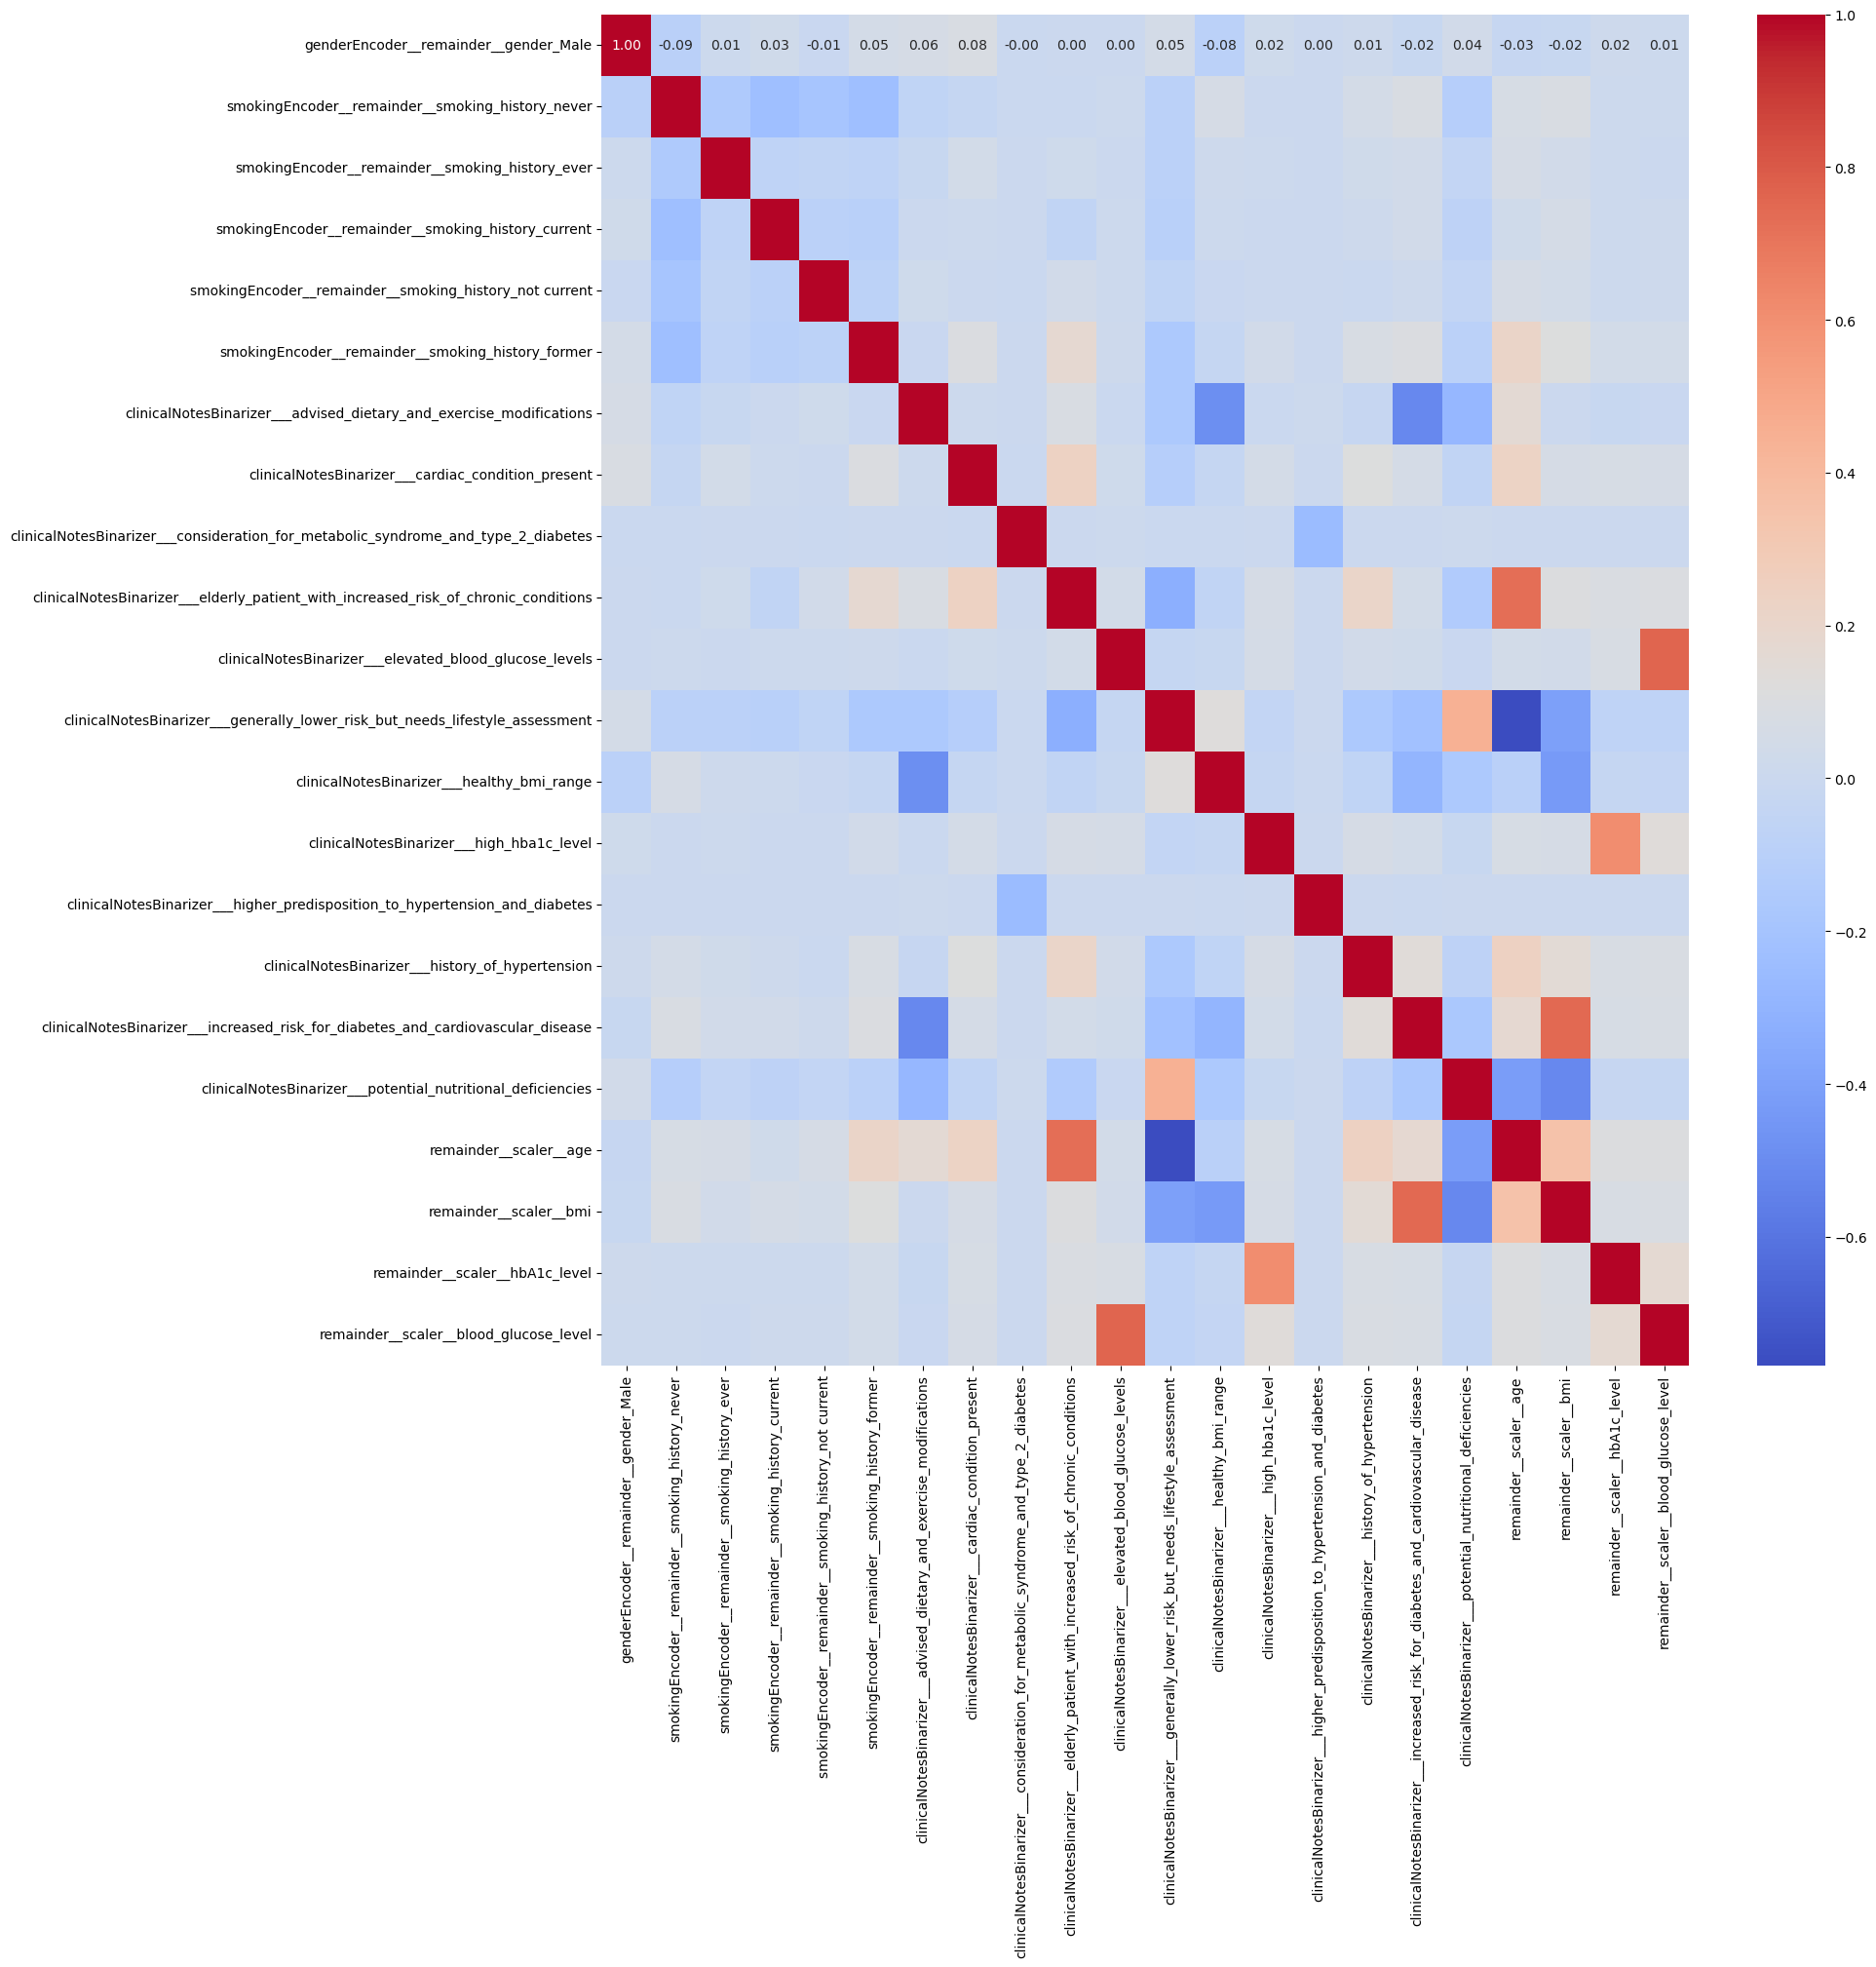

In [44]:
plt.figure(figsize=(18, 18))
sns.heatmap(X_train_transformed_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [56]:
def scores_model(X_train_transformed_df, X_test_transformed_df, model):
    model.fit(X_train_transformed_df, y_train)
    
    # Predictions and probabilities
    y_train_pred = model.predict(X_train_transformed_df)
    y_test_pred = model.predict(X_test_transformed_df)
    y_train_scores = model.predict_proba(X_train_transformed_df)[:, 1]  # Probabilities for training
    y_test_scores = model.predict_proba(X_test_transformed_df)[:, 1]   # Probabilities for test
    
    # Precision-Recall Curves
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
    
    # Evaluate the model
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    train_pr_auc = auc(recall_train, precision_train)  # PR-AUC for training
    test_pr_auc = auc(recall_test, precision_test)     # PR-AUC for test
    train_f1 = f1_score(y_train, y_train_pred)         # F1 score for training
    test_f1 = f1_score(y_test, y_test_pred)            # F1 score for test
    
    # Print results
    print("\nModel Performance:")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Training PR-AUC: {train_pr_auc:.4f}")
    print(f"Test PR-AUC: {test_pr_auc:.4f}")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    return (train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc, train_f1, test_f1)

In [57]:
model = LogisticRegression()
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training ROC-AUC: 0.8108
Test ROC-AUC: 0.8130
Training PR-AUC: 0.8255
Test PR-AUC: 0.8310
Training F1 Score: 0.7359
Test F1 Score: 0.7387
Test Confusion Matrix:
 [[19069   146]
 [  654  1131]]


(0.810778737724598,
 0.8130076074145506,
 0.8254827428707748,
 0.8309939154416266,
 0.7358517062210364,
 0.7387328543435663)

In [58]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)

columns = X_train_transformed_df.columns.tolist()
selected_columns = np.array(columns)[sel.get_support()].tolist()

print("Selected features:", selected_columns)

Selected features: ['smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___history_of_hypertension', 'clinicalNotesBinarizer___increased_risk_for_diabetes_and_cardiovascular_disease', 'clinicalNotesBinarizer___potential_nutritional_deficiencies', 'remainder__scaler__age', 'remainder__scaler__bmi', 'remainder__scaler__hbA1c_level', 'remainder__scaler__blood_glucose_level']


In [59]:
model = LogisticRegression()
scores_model(X_train_sel, X_test_sel, model)


Model Performance:
Training ROC-AUC: 0.8093
Test ROC-AUC: 0.8145
Training PR-AUC: 0.8221
Test PR-AUC: 0.8295
Training F1 Score: 0.7331
Test F1 Score: 0.7413
Test Confusion Matrix:
 [[19071   144]
 [  649  1136]]


(0.8092712494833999,
 0.8144602103136336,
 0.8220768245342833,
 0.8295363941876387,
 0.7330990864371048,
 0.7412724306688417)

In [73]:
model = LogisticRegression(penalty='l1', solver='saga')
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training ROC-AUC: 0.8095
Test ROC-AUC: 0.8154
Training PR-AUC: 0.8226
Test PR-AUC: 0.8298
Training F1 Score: 0.7329
Test F1 Score: 0.7432
Test Confusion Matrix:
 [[19074   141]
 [  646  1139]]


(0.8094555855128938,
 0.8153786104605777,
 0.8225569017273717,
 0.8298457543969348,
 0.7329401853411963,
 0.7432300163132137)

In [60]:
model = KNeighborsClassifier(n_neighbors = 6)
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training ROC-AUC: 0.7880
Test ROC-AUC: 0.7738
Training PR-AUC: 0.8959
Test PR-AUC: 0.7935
Training F1 Score: 0.7253
Test F1 Score: 0.6952
Test Confusion Matrix:
 [[19155    60]
 [  802   983]]


(0.78802406208385,
 0.7737888598062176,
 0.8958639162016258,
 0.793541917577877,
 0.7252714113389626,
 0.6951909476661952)

In [63]:
neighbors = np.arange(1,20)
train_roc_auc = {}
test_roc_auc = {}
train_f1 = {}
test_f1 = {}
train_pr_auc = {}
test_pr_auc = {}
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors = neighbor)
    train_roc_auc[neighbor], test_roc_auc[neighbor], train_pr_auc[neighbor], test_pr_auc[neighbor], train_f1[neighbor], test_f1[neighbor] = scores_model(X_train_transformed_df, X_test_transformed_df, knn)


Model Performance:
Training ROC-AUC: 0.9996
Test ROC-AUC: 0.8118
Training PR-AUC: 0.9992
Test PR-AUC: 0.6845
Training F1 Score: 0.9992
Test F1 Score: 0.6692
Test Confusion Matrix:
 [[18689   526]
 [  623  1162]]

Model Performance:
Training ROC-AUC: 0.8175
Test ROC-AUC: 0.7716
Training PR-AUC: 0.9584
Test PR-AUC: 0.7503
Training F1 Score: 0.7768
Test F1 Score: 0.6858
Test Confusion Matrix:
 [[19126    89]
 [  807   978]]

Model Performance:
Training ROC-AUC: 0.8521
Test ROC-AUC: 0.8009
Training PR-AUC: 0.9334
Test PR-AUC: 0.7728
Training F1 Score: 0.8048
Test F1 Score: 0.7035
Test Confusion Matrix:
 [[18980   235]
 [  689  1096]]

Model Performance:
Training ROC-AUC: 0.7944
Test ROC-AUC: 0.7731
Training PR-AUC: 0.9158
Test PR-AUC: 0.7837
Training F1 Score: 0.7348
Test F1 Score: 0.6913
Test Confusion Matrix:
 [[19141    74]
 [  803   982]]

Model Performance:
Training ROC-AUC: 0.8155
Test ROC-AUC: 0.7952
Training PR-AUC: 0.9043
Test PR-AUC: 0.7899
Training F1 Score: 0.7560
Test F1 Scor

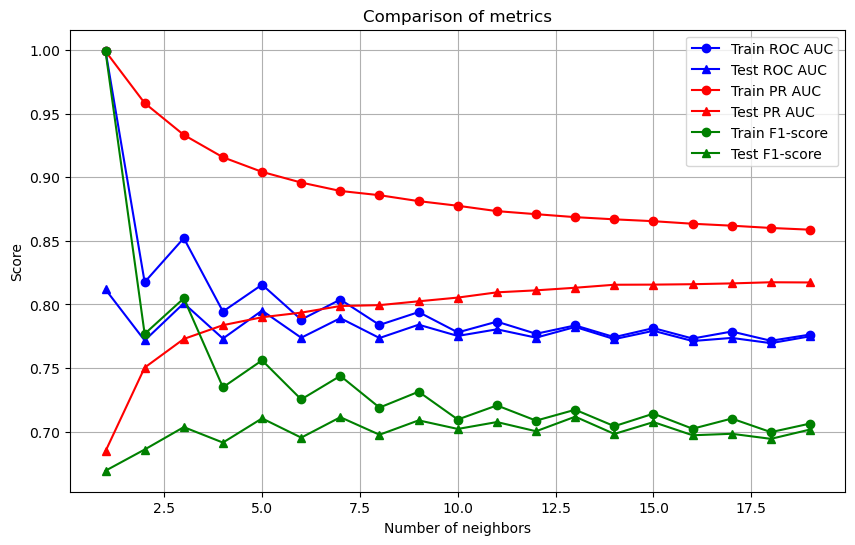

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Wykres dla każdej metryki
plt.plot(neighbors, train_roc_auc.values(), label="Train ROC AUC", marker='o', linestyle='-', color = 'blue')
plt.plot(neighbors, test_roc_auc.values(), label="Test ROC AUC", marker='^', linestyle='-', color = 'blue')

plt.plot(neighbors, train_pr_auc.values(), label="Train PR AUC", marker='o', linestyle='-', color = 'red')
plt.plot(neighbors, test_pr_auc.values(), label="Test PR AUC", marker='^', linestyle='-', color = 'red')

plt.plot(neighbors, train_f1.values(), label="Train F1-score", marker='o', linestyle='-', color = 'green')
plt.plot(neighbors, test_f1.values(), label="Test F1-score", marker='^', linestyle='-', color = 'green')

# Opis osi i tytuł
plt.xlabel("Number of neighbors")
plt.ylabel("Score")
plt.title("Comparison of metrics")
plt.legend()
plt.grid(True)

plt.show()

It seems that the best number of neighbors is 9.